In [2]:
import xarray as xr
from pycaret.regression import *

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
import warnings
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', None)
# Suppress all warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import shap

import seaborn as sns

from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, BboxTransformTo
from matplotlib.transforms import Bbox
import matplotlib as mpl

In [3]:
numeric_features = ['elevation','slope','aspect','fcf','tpi', 'DayOfSeason','sc_percum', 'vv_scaled','cr_scaled', 'lia', 'sc_per']
categorical_features = ['snowclass']
all_features = numeric_features.copy()
all_features.extend(categorical_features)
all_features.append('time')
all_features.append('site')
all_features.append('sd_insitu')
all_features.append('sd_hans')

# Figure 1

In [4]:
with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/figures/shap/shap_s1_new.p', 'rb') as fp:
    all_shap = pickle.load(fp)
 
shap_cols = ['elevation_shap', 'slope_shap',
       'aspect_shape', 'fcf_shap', 'tpi_shap', 'dos_shap',
       'sc_percum_shap', 'sc_per_shap', 'snowclass_shap', 'cr_shap', 'vv_shap', 'lia_shap']

sd_sig = abs(all_shap[shap_cols]).sum(axis = 1)
rel_contr = abs(all_shap[shap_cols]).div(sd_sig, axis='rows')

with open('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/OUTPUT/testing_output/predictions_s1_xg.p', 'rb') as fp:
    all_data = pickle.load(fp) 
    
all_data.loc[all_data.sc_cum < 0.25, 'prediction_label'] = 0

#mod = load_model('/staging/leuven/stg_00024/OUTPUT/devond/S1_ML_project/models/final_model_xg')

In [7]:
rel_contr[c1].mean()

sc_percum_shap    0.251804
sc_per_shap       0.143087
elevation_shap    0.117513
snowclass_shap    0.097827
dos_shap          0.089545
cr_shap           0.071081
vv_shap           0.062874
aspect_shape      0.047405
tpi_shap          0.045253
slope_shap        0.039983
fcf_shap          0.021594
lia_shap          0.012033
dtype: float32

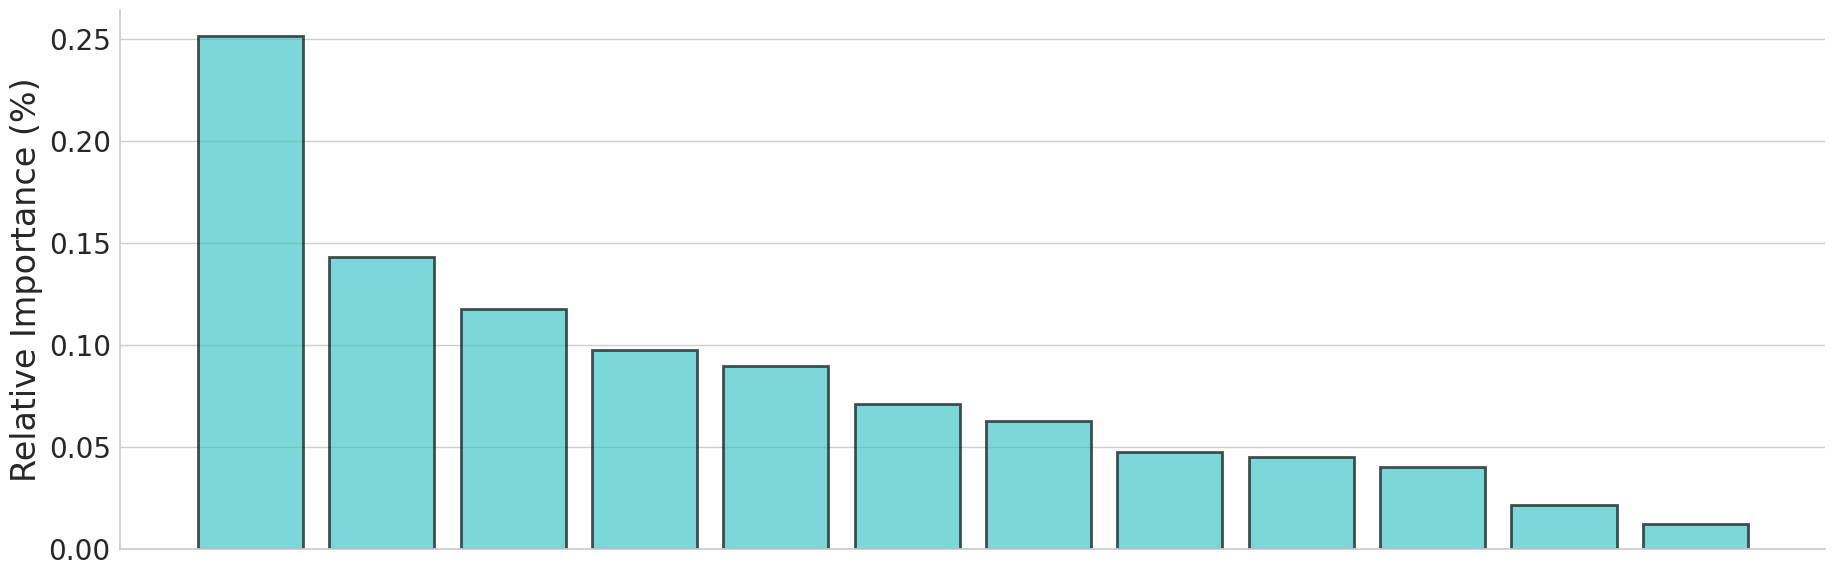

In [6]:
c1 = ['sc_percum_shap', 'sc_per_shap', 'elevation_shap','snowclass_shap', 'dos_shap','cr_shap', 'vv_shap',\
      'aspect_shape','tpi_shap', 'slope_shap', 'fcf_shap', 'lia_shap']

fig, ax = plt.subplots(1,1,figsize = (22,7))
plt.bar(shap_cols, rel_contr[c1].mean(), edgecolor='black', alpha = 0.2,linewidth = 2)

ax.bar(shap_cols, rel_contr[c1].mean(), edgecolor='black', color = 'mediumturquoise', alpha = 0.6, linewidth = 2)
ax.set_ylabel('Relative Importance (%)', fontsize = 24)
ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize = 20)
ax.grid(axis = 'x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([]);
plt.savefig('panels/all_shap.png', dpi = 300, bbox_inches = 'tight')

In [9]:
def get_site_shap(s):
    df_s = all_data.loc[all_data.site==s]
    df_s.loc[df_s.sc_percum<0.25,'prediction_label'] = 0
    df_s = df_s.sort_values(by = 'time')
    df_s = df_s[(df_s.time > pd.Timestamp(2017,8,1))&(df_s.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)

    data_features= df_s[all_features]
    data_features2 = data_features.drop(columns = ['time','site','sd_insitu','sd_hans'])
    explainer = shap.TreeExplainer(mod.named_steps["actual_estimator"])
    data_pipe = mod[:-1].transform(data_features2)
    shap1 = explainer(data_pipe)
    df = pd.DataFrame(columns = data_pipe.columns, data = shap1.values)
    df['snowclass'] = df['snowclass_1.0']+df['snowclass_3.0']+df['snowclass_5.0']+df['snowclass_6.0']+df['snowclass_7.0']+df['snowclass_2.0']+df['snowclass_4.0']
    df = df.drop(columns = ['snowclass_1.0','snowclass_3.0','snowclass_5.0','snowclass_6.0','snowclass_7.0','snowclass_2.0','snowclass_4.0'])
    df = df.rename(columns = {'elevation':'elevation_shap',\
                     'slope':'slope_shap','aspect':'aspect_shap','fcf':'fcf_shap','tpi':'tpi_shap','DayOfSeason':'dos_shap',\
                              'sc_percum':'sc_shap','vv_scaled':'vv_shap','snowclass':'snowclass_shap', 'cr_scaled':'cr_shap','lia':'lia_shap','ad':'ad_shap'})

    all_data_sub2 = df_s.reset_index(drop = True)
    all_shap2 = df.join(all_data_sub2)
    
    return all_shap2

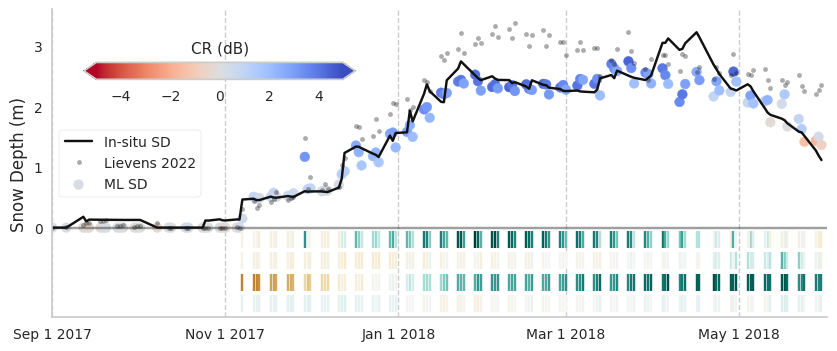

In [5]:
s = 655

df_s = all_shap[all_shap.site==s]
df_s = df_s.sort_values(by = 'time')
df_s = df_s[(df_s.time > pd.Timestamp(2017,8,1))&(df_s.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)
    
df_s2 = all_data[all_data.site==s]
df_s2 = df_s2.sort_values(by = 'time')
df_s2 = df_s2[(df_s2.time > pd.Timestamp(2017,8,1))&(df_s2.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)

fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(df_s2.time, df_s2.sd_insitu, 'k', label = 'In-situ SD')
ax.plot(df_s2.time, df_s2.sd_hans, '.', c = 'k', label = 'Lievens 2022', alpha = 0.35)
im = ax.scatter(df_s2.time, df_s2.prediction_label, c = df_s2.cr_scaled, cmap = 'coolwarm_r', vmin = -5, vmax = 5, label = 'ML SD')
ax.set_xticks([pd.Timestamp(2017,9,1),pd.Timestamp(2017,11,1),pd.Timestamp(2018,1,1),pd.Timestamp(2018,3,1),pd.Timestamp(2018,5,1)])
ax.scatter(df_s.time, np.ones(len(df_s))-1.2,c = df_s.cr_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.55, c = df_s.vv_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.9, c = df_s.sc_percum_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-2.25 ,c = df_s.elevation_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.set_yticks([0,1,2,3])

ax.plot([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)], [0,0], 'k-', alpha = 0.4)
ax.set_xlim([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)])
ax.set_xticklabels(['Sep 1 2017','Nov 1 2017','Jan 1 2018','Mar 1 2018','May 1 2018'])
ax.set_ylabel('Snow Depth (m)', fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.grid(which='major', axis='x', linestyle='--')
ax.legend(loc = 'center left',frameon = True)

bbox = Bbox.from_bounds(-0.3, 0.75, 0.7, 1.1)
cax = inset_axes(ax, width="50%", height="5%", loc='lower right', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
cbar = plt.colorbar(im, cax=cax, extend='both', orientation='horizontal')
cbar.set_label(label='CR (dB)', labelpad=-45) 

plt.savefig('panels/site_cr.png', dpi = 300, bbox_inches = 'tight')

In [13]:
df_s.mean()

elevation_shap         0.017640
slope_shap             0.019244
aspect_shape           0.000949
fcf_shap               0.002362
tpi_shap               0.130348
dos_shap               0.034527
sc_percum_shap         0.289910
vv_shap               -0.004156
cr_shap                0.262656
lia_shap              -0.007365
sc_per_shap            0.183180
snowclass_shap         0.111422
site                 655.000000
lat                   46.465729
lon                    8.717474
sd_hans                2.267963
wet_hans               0.619100
ims                    0.990196
sc_cum               103.411766
sc_per                 0.848906
sc_percum             89.650642
elevation           2222.896240
slope                 11.576913
aspect               311.995422
tpi                  -13.028320
fcf                    0.000000
landcover             30.000000
snowclass              1.000000
vv                   -11.210669
vh                   -17.295071
cr                    -6.084398
vv_scale

In [10]:
df_s[df_s.time.dt.month.isin([5])].mean()

elevation_shap         0.029447
slope_shap             0.025138
aspect_shape           0.053498
fcf_shap               0.016045
tpi_shap               0.122671
dos_shap              -0.072728
sc_percum_shap         0.571438
vv_shap                0.137425
cr_shap               -0.002740
lia_shap              -0.029455
sc_per_shap           -0.002021
snowclass_shap         0.147240
site                 655.000000
lat                   46.465717
lon                    8.717474
sd_hans                2.410882
wet_hans               0.999225
ims                    1.000000
sc_cum               192.000000
sc_per                 0.666056
sc_percum            167.120300
elevation           2222.896240
slope                 11.576915
aspect               311.995422
tpi                  -13.028320
fcf                    0.000000
landcover             30.000000
snowclass              1.000000
vv                   -13.801313
vh                   -21.569832
cr                    -7.768517
vv_scale

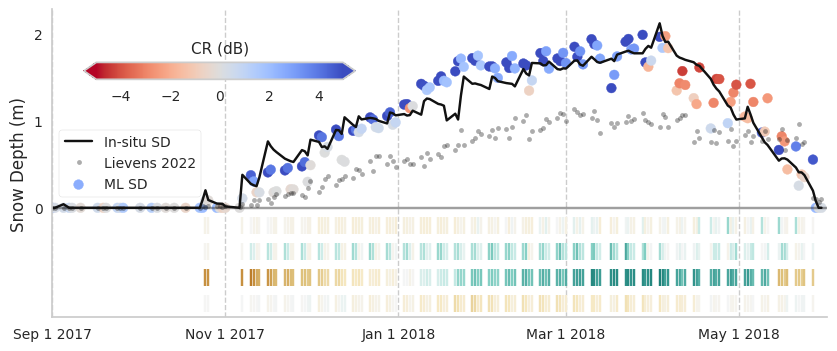

In [19]:
s = 712

df_s = all_shap[all_shap.site==s]
df_s = df_s.sort_values(by = 'time')
df_s = df_s[(df_s.time > pd.Timestamp(2017,8,1))&(df_s.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)
    
df_s2 = all_data[all_data.site==s]
df_s2 = df_s2.sort_values(by = 'time')
df_s2 = df_s2[(df_s2.time > pd.Timestamp(2017,8,1))&(df_s2.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)

fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(df_s2.time, df_s2.sd_insitu, 'k', label = 'In-situ SD')
ax.plot(df_s2.time, df_s2.sd_hans, '.', c = 'k', label = 'Lievens 2022', alpha = 0.35)
im = ax.scatter(df_s2.time, df_s2.prediction_label, c = df_s2.vv_scaled, cmap = 'coolwarm_r', vmin = -5, vmax = 5, label = 'ML SD')
ax.set_xticks([pd.Timestamp(2017,9,1),pd.Timestamp(2017,11,1),pd.Timestamp(2018,1,1),pd.Timestamp(2018,3,1),pd.Timestamp(2018,5,1)])
ax.scatter(df_s.time, np.ones(len(df_s))-1.2,c = df_s.cr_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.5, c = df_s.vv_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.8, c = df_s.sc_percum_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-2.1 ,c = df_s.elevation_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.set_yticks([0,1,2,3])

ax.plot([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)], [0,0], 'k-', alpha = 0.4)
ax.set_xlim([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)])
ax.set_xticklabels(['Sep 1 2017','Nov 1 2017','Jan 1 2018','Mar 1 2018','May 1 2018'])
ax.set_ylabel('Snow Depth (m)', fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.grid(which='major', axis='x', linestyle='--')
ax.legend(loc = 'center left',frameon = True)

bbox = Bbox.from_bounds(-0.3, 0.75, 0.7, 1.1)
cax = inset_axes(ax, width="50%", height="5%", loc='lower right', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
cbar = plt.colorbar(im, cax=cax, extend='both', orientation='horizontal')
cbar.set_label(label='CR (dB)', labelpad=-45) 

plt.savefig('panels/site_vv.png', dpi = 300, bbox_inches = 'tight')

In [20]:
df_s.mean()

elevation_shap        -0.069017
slope_shap             0.043272
aspect_shape          -0.018347
fcf_shap              -0.007726
tpi_shap              -0.044585
dos_shap               0.012225
sc_percum_shap         0.126129
vv_shap                0.119091
cr_shap               -0.025556
lia_shap               0.005442
sc_per_shap            0.093394
snowclass_shap        -0.023925
site                 712.000000
lat                   46.618649
lon                    7.943542
sd_hans                0.687696
wet_hans               0.814414
ims                    1.000000
sc_cum                86.022560
sc_per                 0.737878
sc_percum             66.460144
elevation           2144.104736
slope                 20.048309
aspect               103.841743
tpi                    0.219543
fcf                    3.000000
landcover             30.000000
snowclass              3.000000
vv                    -8.582629
vh                   -18.171236
cr                    -9.588605
vv_scale

In [35]:
df_s[df_s.vv_shap == df_s.vv_shap.max()]

,elevation_shap,slope_shap,aspect_shape,fcf_shap,tpi_shap,dos_shap,sc_percum_shap,vv_shap,cr_shap,lia_shap,sc_per_shap,snowclass_shap,site,time,lat,lon,sd_hans,wet_hans,ims,sc_cum,sc_per,sc_percum,elevation,slope,aspect,tpi,fcf,landcover,snowclass,vv,vh,cr,vv_scaled,vh_scaled,cr_scaled,lia,orbit,ad,satellite,fold,DayOfSeason,sd_insitu,prediction_label
90,-0.176568,0.070177,-0.046068,-0.004094,-0.061008,0.022371,0.469376,0.409411,0.013533,0.016011,0.230104,0.023423,712.0,2018-03-22,46.618649,7.943542,0.990121,0.808081,1.0,136.0,0.86784,109.5839,2144.104736,20.048307,103.841743,0.219543,3.0,30.0,3.0,-1.162588,-13.751095,-12.588507,8.877574,5.624819,0.829367,18.713846,139.0,2.0,2.0,3.0,233.0,1.8,1.91306


In [37]:
(df_s2.sd_hans - df_s2.sd_insitu).mean()

-0.4079569

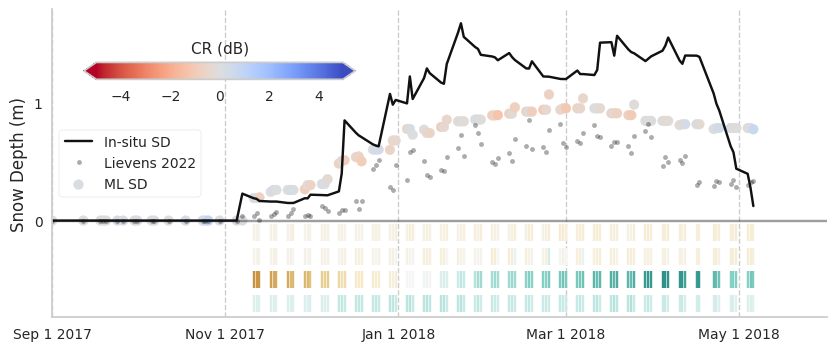

In [38]:
s = 717

df_s = all_shap[all_shap.site==s]
df_s = df_s.sort_values(by = 'time')
df_s = df_s[(df_s.time > pd.Timestamp(2017,8,1))&(df_s.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)
    
df_s2 = all_data[all_data.site==s]
df_s2 = df_s2.sort_values(by = 'time')
df_s2 = df_s2[(df_s2.time > pd.Timestamp(2017,8,1))&(df_s2.time < pd.Timestamp(2018,6,1))].reset_index(drop = True)

fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(df_s2.time, df_s2.sd_insitu, 'k', label = 'In-situ SD')
ax.plot(df_s2.time, df_s2.sd_hans, '.', c = 'k', label = 'Lievens 2022', alpha = 0.35)
im = ax.scatter(df_s2.time, df_s2.prediction_label, c = df_s2.cr_scaled, cmap = 'coolwarm_r', vmin = -5, vmax = 5, label = 'ML SD')
ax.set_xticks([pd.Timestamp(2017,9,1),pd.Timestamp(2017,11,1),pd.Timestamp(2018,1,1),pd.Timestamp(2018,3,1),pd.Timestamp(2018,5,1)])
ax.scatter(df_s.time, np.ones(len(df_s))-1.1,c = df_s.cr_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.3, c = df_s.vv_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.5, c = df_s.sc_percum_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.scatter(df_s.time, np.ones(len(df_s))-1.7 ,c = df_s.elevation_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
ax.set_yticks([0,1,2,3])

ax.plot([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)], [0,0], 'k-', alpha = 0.4)
ax.set_xlim([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)])
ax.set_xticklabels(['Sep 1 2017','Nov 1 2017','Jan 1 2018','Mar 1 2018','May 1 2018'])
ax.set_ylabel('Snow Depth (m)', fontsize = 12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.grid(which='major', axis='x', linestyle='--')
ax.legend(loc = 'center left',frameon = True)

bbox = Bbox.from_bounds(-0.3, 0.75, 0.7, 1.1)
cax = inset_axes(ax, width="50%", height="5%", loc='lower right', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
cbar = plt.colorbar(im, cax=cax, extend='both', orientation='horizontal')
cbar.set_label(label='CR (dB)', labelpad=-45) 
plt.savefig('panels/site_other.png', dpi = 300, bbox_inches = 'tight')

In [39]:
df_s.mean()

elevation_shap         0.132701
slope_shap             0.012037
aspect_shape          -0.075054
fcf_shap              -0.035158
tpi_shap              -0.011743
dos_shap              -0.019566
sc_percum_shap         0.122702
vv_shap               -0.049680
cr_shap               -0.067846
lia_shap               0.002547
sc_per_shap           -0.148284
snowclass_shap         0.058449
site                 717.000000
lat                   46.408726
lon                    8.917593
sd_hans                0.434434
wet_hans               0.795469
ims                    1.000000
sc_cum                91.213486
sc_per                 0.729318
sc_percum             66.818367
elevation           1859.451050
slope                 22.032713
aspect               207.732910
tpi                    4.789078
fcf                   64.000000
landcover            126.000000
snowclass              3.000000
vv                    -8.118886
vh                   -14.837159
cr                    -6.718274
vv_scale

In [44]:
np.abs((df_s2.sd_hans - df_s2.sd_insitu)/df_s2.sd_insitu).mean()

0.58940613

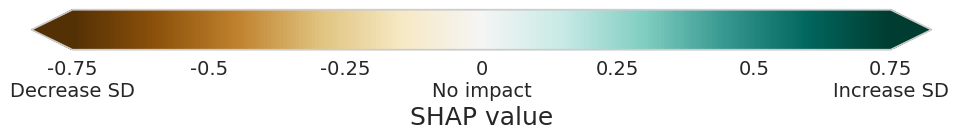

In [52]:
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='BrBG', extend = 'both')
cb.set_label('Point density', fontsize = 18)
cb.set_ticks([0,0.5/3,1/3,0.5,2/3,2.5/3,1])
cb.set_ticklabels(['-0.75\nDecrease SD', '-0.5','-0.25','0\nNo impact','0.25','0.5','0.75\nIncrease SD'], fontsize = 14)
cb.set_label('SHAP value', fontsize = 18)
plt.savefig('panels/brbg_colorbar.png', bbox_inches='tight', transparent = True, dpi = 300)

In [4]:
elevation = xr.open_dataset('/staging/leuven/stg_00024/OUTPUT/devond/Microwave_practical/elevation.nc')
background = np.zeros(elevation.Elevation_inst.values.shape)

In [29]:
nimes = pd.read_csv('../../NIME_Meta.csv', delimiter = '\t')
imis = pd.read_csv('../../IMIS_Meta.csv', delimiter = '\t')
snowmos = pd.read_csv('../../Snomos_Meta.csv', delimiter = '\t')
po = xr.open_dataset('../../_1_in_situ_data/po_4DMED.nc')

In [30]:
po

<xarray.Dataset>
Dimensions:    (time: 2650, site: 130)
Coordinates:
  * site       (site) object 'Data_100' 'Data_101' ... 'Data_97' 'Data_98'
  * time       (time) datetime64[ns] 2015-10-01 2015-10-02 ... 2023-01-01
Data variables:
    lat        (time, site) float64 ...
    lon        (time, site) float64 ...
    sd_insitu  (time, site) float64 ...

(45.5, 47.0)

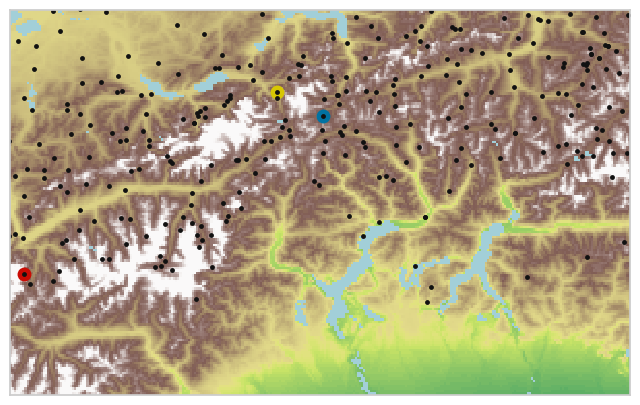

In [169]:
# Example colormaps
cmap1 = plt.cm.ocean_r
cmap2 = plt.cm.summer
cmap3 = plt.cm.terrain

colors1 = cmap1(np.linspace(0.7, 1,10))
colors2 = cmap2(np.linspace(0.25, 0.9, 50))
colors3 = cmap3(np.linspace(0.55, 0.8, 400))
colors4 = cmap3(np.linspace(0.8, 1, 100))
colors = np.vstack((colors1, colors2, colors3, colors4))

x = pd.DataFrame(colors)
x = x.rolling(window = 20, min_periods = 1, center = True).mean()
colors3 = x.values

blended_cmap = LinearSegmentedColormap.from_list('blended_cmap', colors3)

fig, ax = plt.subplots(1,1,figsize = (8,5))
ax.pcolormesh(elevation.lon, elevation.lat, background, cmap = 'Spectral', vmin = -150, vmax = 25, alpha = 0.5)
im1 = ax.pcolormesh(elevation.lon, elevation.lat, elevation.Elevation_inst, cmap = blended_cmap, vmin = -0, vmax = 3000)
ax.plot(all_data[all_data.site == 679].mean().lon, all_data[all_data.site == 679].mean().lat,'r.', markersize = 20)
ax.plot(all_data[all_data.site == 764].mean().lon, all_data[all_data.site == 764].mean().lat,'b.', markersize = 20)
ax.plot(all_data[all_data.site == 692].mean().lon, all_data[all_data.site == 692].mean().lat,'y.', markersize = 20)
ax.plot(nimes.WGS84_LONGITUDE, nimes.WGS84_LATITUDE, 'k.')
ax.plot(imis.WGS84_LONGITUDE, imis.WGS84_LATITUDE, 'k.')
ax.plot(snowmos.WGS84_LONGITUDE, snowmos.WGS84_LATITUDE, 'k.')
#ax.plot(po.lon.values, po.lat.values, 'k.')

#lg.set_title('# Observations', fontsize = 20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([7, 10])
ax.set_ylim([45.5,  47.])


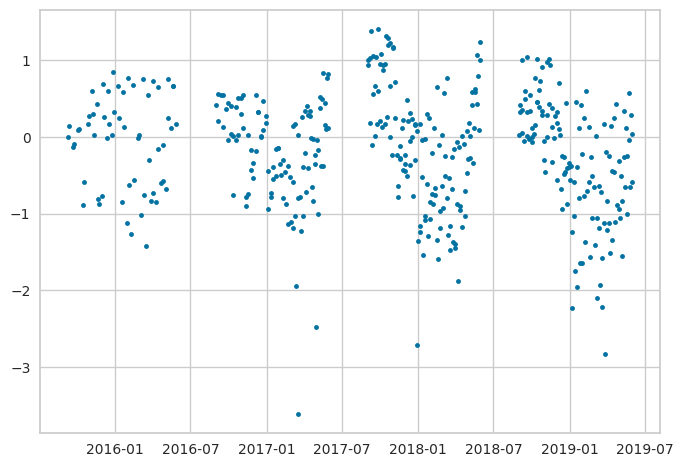

In [178]:
x = all_data[all_data.site==692]
plt.plot(x.time, x.cr_scaled, '.')

In [35]:
import math
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance

In [164]:
s = 764
lat2 = all_data[all_data.site == s].mean().lat
lon2 = all_data[all_data.site == s].mean().lon

mind = 10000

for i, row in imis.iterrows():
    lat1 = row.WGS84_LATITUDE
    lon1 = row.WGS84_LONGITUDE

    d = haversine(lat1, lon1, lat2, lon2)
    if d < mind:
        mini = i
        mind = d

In [165]:
imis.iloc[mini]

STAT                    URS2
COUNTRY                   CH
WGS84_LATITUDE     46.586787
WGS84_LONGITUDE      8.51386
STAO_H                  2169
Name: 134, dtype: object

In [122]:
s = 96
for m in [10,11,12,1,2,3,4,5]:
    if m <= 5: y = 2018
    else: y = 2017
    
    if m == 12:
        m2 = 1
        y2 = y+1
    else:
        m2 = m+1
        y2 = y
    
    print(y,m,y2,m2,all_data[(all_data.site == s)&(all_data.time >= pd.Timestamp(y,m,1))&(all_data.time < pd.Timestamp(y2,m2,1))].mean().vv_scaled)

    print(all_shap[(all_shap.site == s)&(all_shap.time >= pd.Timestamp(y,m,1))&(all_shap.time < pd.Timestamp(y2,m2,1))].mean().vv_shap)

2017 10 2017 11 -0.100419894
nan
2017 11 2017 12 0.5661198
-0.039909575
2017 12 2018 1 0.34620523
-0.041432463
2018 1 2018 2 -0.14053631
-0.011510832
2018 2 2018 3 3.0348537
0.21617405
2018 3 2018 4 2.28674
0.15820634
2018 4 2018 5 -1.1133808
0.019217627
2018 5 2018 6 1.0153203
-0.123947814


In [135]:
x = all_shap[(all_shap.site == 625)&(all_shap.time >= pd.Timestamp(2017,9,1))&(all_shap.time < pd.Timestamp(2018,5,1))]
np.abs(x.prediction_label - x.sd_insitu).mean()

0.43709219

In [ ]:
for s in imis.STAT.values[129:]:
    lat1 = imis[imis.STAT == s].WGS84_LATITUDE
    lon1 = imis[imis.STAT == s].WGS84_LONGITUDE
    mind = 10000

    for i in set(all_data.site.values):
        lat2 = all_data[all_data.site == i].mean().lat
        lon2 = all_data[all_data.site == i].mean().lon
        d = haversine(lat1, lon1, lat2, lon2)
        if d < mind:
            mini = i
            mind = d
         
    if True:#mini>660:
        print(mini, imis[imis.STAT == s].STAO_H)

        df_s = get_site_shap(mini)

        fig, ax = plt.subplots(1,1, figsize = (10,4))
        ax.plot(df_s.time, df_s.sd_insitu, 'k', label = 'In-situ SD')
        ax.plot(df_s.time, df_s.sd_hans, '.', c = 'k', label = 'Lievens 2022', alpha = 0.35)
        im = ax.scatter(df_s.time, df_s.prediction_label, c = df_s.cr_scaled, cmap = 'coolwarm_r', vmin = -5, vmax = 5, label = 'ML SD')
        ax.set_xticks([pd.Timestamp(2017,9,1),pd.Timestamp(2017,11,1),pd.Timestamp(2018,1,1),pd.Timestamp(2018,3,1),pd.Timestamp(2018,5,1)])
        ax.scatter(df_s.time, np.ones(len(df_s))-1.2,c = df_s.cr_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
        ax.scatter(df_s.time, np.ones(len(df_s))-1.4, c = df_s.vv_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
        ax.scatter(df_s.time, np.ones(len(df_s))-1.6, c = df_s.sc_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
        ax.scatter(df_s.time, np.ones(len(df_s))-1.8 ,c = df_s.elevation_shap, vmin = -0.75, vmax = 0.75, cmap = 'BrBG', marker = "|", s = 150)
        ax.set_yticks([0,0.5,1,1.5])

        ax.plot([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)], [0,0], 'k-', alpha = 0.4)
        ax.set_xlim([pd.Timestamp(2017,9,1), pd.Timestamp(2018,6,1)])
        ax.set_xticklabels(['Sep 1 2017','Nov 1 2017','Jan 1 2018','Mar 1 2018','May 1 2018'])
        ax.set_ylabel('Snow Depth (m)', fontsize = 12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.grid(which='major', axis='x', linestyle='--')
        ax.legend(loc = 'center left',frameon = True)

        bbox = Bbox.from_bounds(-0.3, 0.75, 0.7, 1.1)
        cax = inset_axes(ax, width="50%", height="5%", loc='lower right', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
        cbar = plt.colorbar(im, cax=cax, extend='both', orientation='horizontal')
        cbar.set_label(label='VV (dB)', labelpad=-45)  # Adjust the labelpad value as needed
        plt.show()
    #plt.savefig('panels/vv_shap.png', dpi = 300, bbox_inches = 'tight')